In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-pickle/riiid_train.pkl.gzip
/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter


In [3]:
import pandas as pd
import dask.dataframe as dd
import pickle

In [4]:
%%time

#pickle로 변환한 Train 데이터셋 가져오기
#refer. : https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets/
train = pd.read_pickle("../input/riiid-pickle/riiid_train.pkl.gzip")

print("Train size:", train.shape)

Train size: (101230332, 10)
CPU times: user 4.51 s, sys: 5.4 s, total: 9.91 s
Wall time: 28.9 s


In [8]:
#메모리 사용량 체크

train.memory_usage(deep=True)

Index                                    128
row_id                             809842656
timestamp                          809842656
user_id                            404921328
content_id                         202460664
content_type_id                    101230332
task_container_id                  202460664
user_answer                        101230332
answered_correctly                 101230332
prior_question_elapsed_time        404921328
prior_question_had_explanation    3594972816
dtype: int64

In [9]:
# 데이터셋 기초 정보

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 bool   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  object 
dtypes: bool(1), float32(1), int16(2), int32(1), int64(2), int8(2), object(1)
memory usage: 3.7+ GB


"prior_question_had_explanation" 의 데이터타입이 object이면서 많은 메모리를 차지하고 있다.

해당 컬럼은, 0과1로 이루어진 이진 변수여야 하므로 이를 수정해준다.

In [5]:
train["prior_question_had_explanation"]=train["prior_question_had_explanation"].astype("boolean")

In [6]:
train.memory_usage(deep=True)

Index                                   128
row_id                            809842656
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   101230332
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    202460664
dtype: int64

prior_question_had_explanation컬럼의 메모리 사용량이 줄어든 것을 확인할 수 있다.

In [7]:
%%time

questions = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/questions.csv')
lectures = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/lectures.csv')
example_test = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_test.csv')
example_sample_submission = pd.read_csv('/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv')

CPU times: user 20.2 ms, sys: 4.26 ms, total: 24.4 ms
Wall time: 48.9 ms


In [14]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,<NA>
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False
5,5,157063,115,156,False,5,2,1,5000.0,False
6,6,176092,115,51,False,6,0,1,17000.0,False
7,7,194190,115,50,False,7,3,1,17000.0,False
8,8,212463,115,7896,False,8,2,1,16000.0,False
9,9,230983,115,7863,False,9,0,1,16000.0,False


In [17]:
# 유저의 수

print(f'We have {train.user_id.nunique()} unique users in our train set')

We have 393656 unique users in our train set


In [18]:
# content_type_id 의 데이터 비율
# 0은 문제를 풀고 있다. 1은 강의를 보고 있다.


train.content_type_id.value_counts()

False    99271300
True      1959032
Name: content_type_id, dtype: int64

In [19]:
print(f'We have {train.content_id.nunique()} content ids in our train set, of which {train[train.content_type_id == False].content_id.nunique()} are questions.')

We have 13782 content ids in our train set, of which 13523 are questions.


content_id는 유저가 상호작용하고 있는, 컨텐츠의 아이디를 나타낸다. 만약 content_id_type==False 이면, 문제의 ID일 것이고 True이면 강의의 ID일 것이다.

총 13782의 content_id중 13523개가 강의를 나타내는 것을 확인할 수 있다.

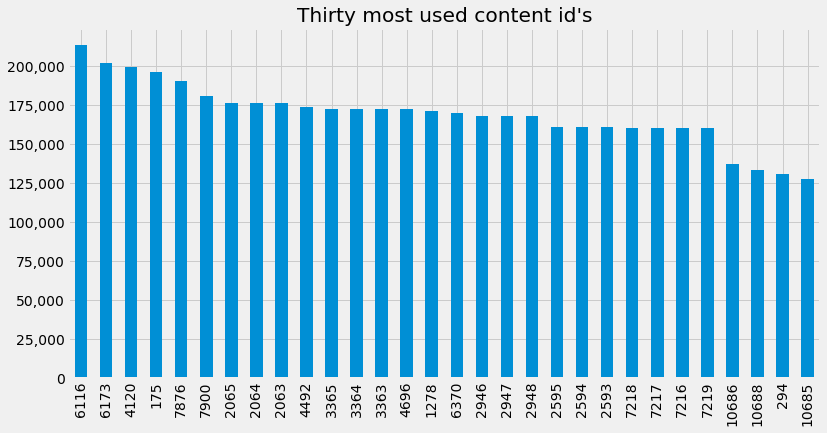

In [22]:
cids=train.content_id.value_counts()[:30]

fig=plt.figure(figsize=(12,6))
ax=cids.plot.bar()
plt.title("Thirty most used content id's")
plt.xticks(rotation=90)

#y축 자리수 변환
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [25]:
print(f'We have {train.task_container_id.nunique()} unique Batches of questions or lectures.')

We have 10000 unique Batches of questions or lectures.


task_container_id는 설명을 보기전까지 유저가 받은 문제의 세트 번호이다. 

만약 3문제를 연속으로 받았다면, 그 3문제가 한 batch로 묶인다.

In [26]:
train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

유저가 선택한 답의 분포이다. 총 4문항(0~3)으로 확인되며, -1은 답을 하지 않은 것이다.(강의를 봄)

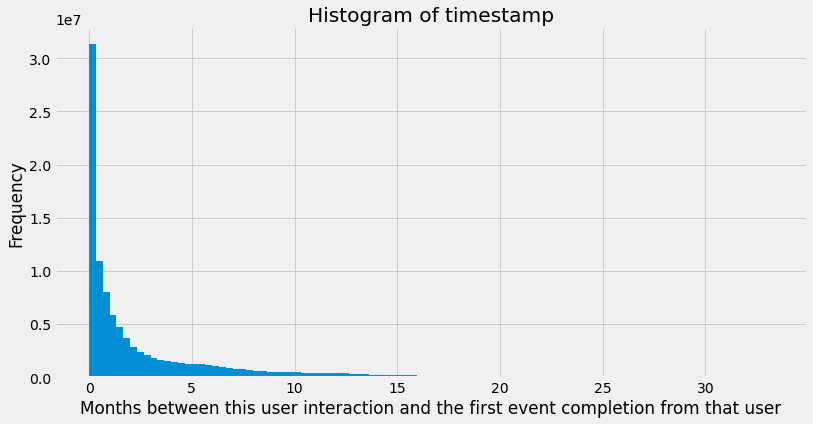

In [7]:
#1 year = 31536000000 ms
ts = train['timestamp']/(31536000000/12)
fig=plt.figure(figsize=(12,6))
ts.plot.hist(bins=100)
plt.title("Histogram of timestamp")
plt.xticks(rotation=0)
plt.xlabel("Months between this user interaction and the first event completion from that user")
plt.show()

In [8]:
print(f'Of the {train.user_id.nunique()} users in train we have {train[train.timestamp == 0].user_id.nunique()} users with a timestamp zero row.')

Of the 393656 users in train we have 393656 users with a timestamp zero row.


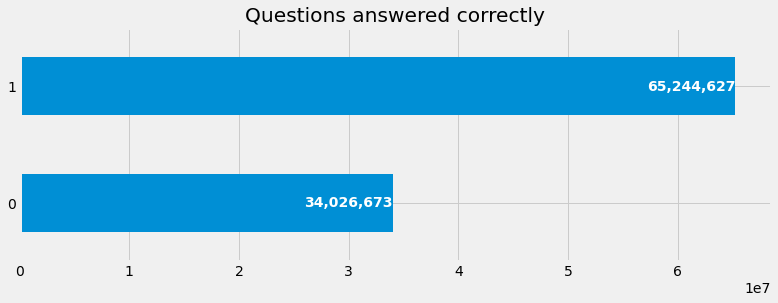

In [10]:
# target value

# 강의를 보지 않은 것들만 체크
correct=train[train.answered_correctly!=-1].answered_correctly.value_counts(ascending=True)

fig=plt.figure(figsize=(12,4))
correct.plot.barh()

for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Questions answered correctly")
plt.xticks(rotation=0)
plt.show()


전체 데아터의 1/3이 오답인 것을 볼 수 있다.

In [15]:
train.answered_correctly.value_counts()

 1    65244627
 0    34026673
-1     1959032
Name: answered_correctly, dtype: int64

In [8]:
# timestamp와 answered_correctly의 관계
# 과연 사용 시간이 정답률과 관계가 있을까?


#make function that can also be used for other fields
def correct(field):
    
    #answered_correctly로 그룹화(0그룹, 1그룹 )후 각 그룹의 사이즈 구하기
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    
    #pivot을 이용하여 answered_correctly를 열로 전환(0열, 1열)
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    
    #정답의 비율
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)

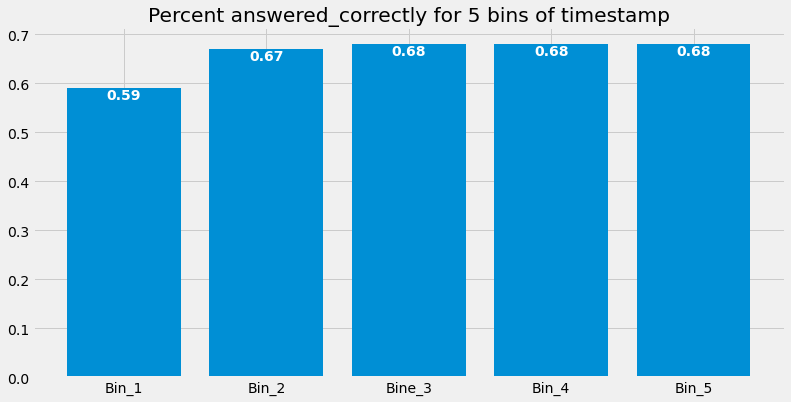

In [7]:
# timestamp와 answered_correctly의 관계
# 과연 사용 시간이 정답률과 관계가 있을까?


#시계열을 5구간으로 나누기
bin_labels_5=["Bin_1","Bin_2","Bine_3","Bin_4","Bin_5"]
train["ts_bin"]=pd.qcut(train["timestamp"],q=5,labels=bin_labels_5)


bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()


fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Percent answered_correctly for 5 bins of timestamp")
plt.xticks(rotation=0)
plt.show()

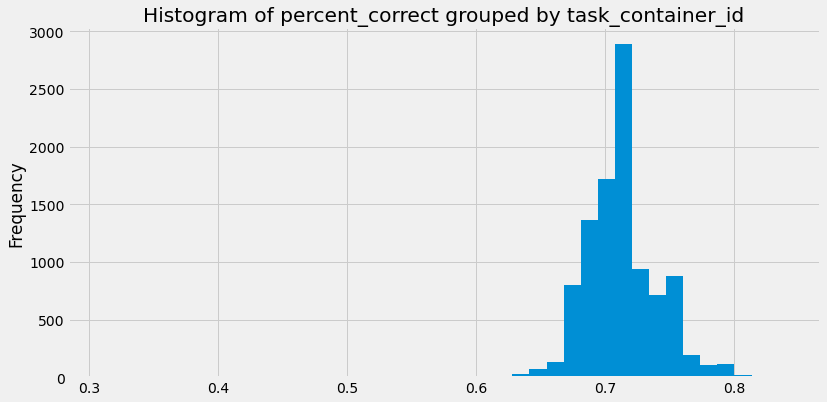

In [9]:
# 

task_id_correct=correct("task_container_id")

fig = plt.figure(figsize=(12,6))
task_id_correct.plot.hist(bins=40)
plt.title("Histogram of percent_correct grouped by task_container_id")
plt.xticks(rotation=0)
plt.show()

In [10]:
# 푼 문제 수와, 정답률의 관계
# 샘플 200

user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'the highest number of questions answered by a user is {user_percent.Answers.max()}')

the highest number of questions answered by a user is 17609


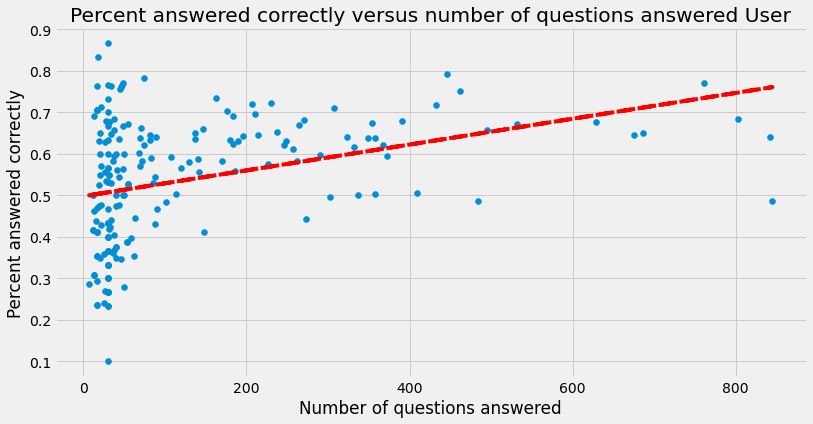

In [11]:
user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered User")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")

# x,y와의 1차 회귀선 
z = np.polyfit(x, y, 1)

#1차 함수 
p = np.poly1d(z)

plt.plot(x,p(x),"r--")

plt.show()

대체적으로 푼 문제의 수가 올라갈수록 정답률도 상승하는 것을 볼 수 있지만, 푼 문제의 개수 0~100 부근에서 편차가 심한것을 볼 수 있다.

In [ ]:
content_percent=train[train.answered_correctly=-1].groupby("content_id")[""].agg(Mean="mean",Answers="count")

In [14]:
#content_id 와 정답률의 관계
# 샘플 200

content_percent = train[train.answered_correctly != -1].groupby('content_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'The highest number of questions asked by content_id is {content_percent.Answers.max()}.')
print(f'Of {len(content_percent)} content_ids, {len(content_percent[content_percent.Answers > 25000])} content_ids had more than 25,000 questions asked.')

The highest number of questions asked by content_id is 213605.
Of 13523 content_ids, 529 content_ids had more than 25,000 questions asked.


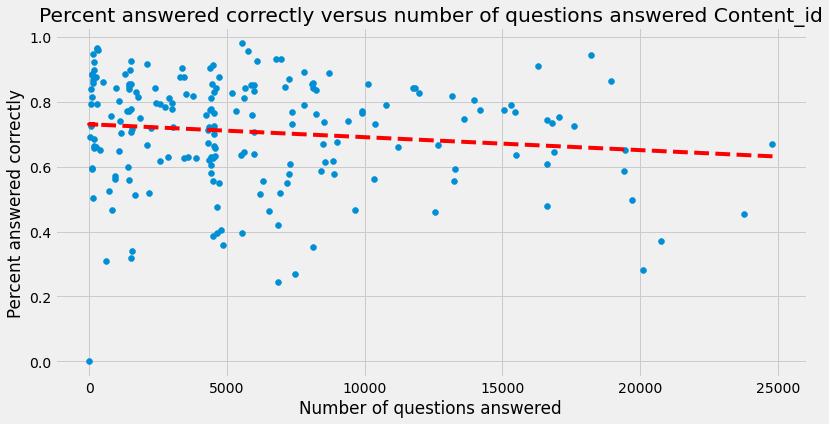

In [15]:
content_percent = content_percent.query('Answers <= 25000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = content_percent.Answers
y = content_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Percent answered correctly versus number of questions answered Content_id")
plt.xticks(rotation=0)
plt.xlabel("Number of questions answered")
plt.ylabel("Percent answered correctly")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

prior_question_had_explanation
False     9193234
True     89685560
NaN        392506
Name: (answered_correctly, count), dtype: int64


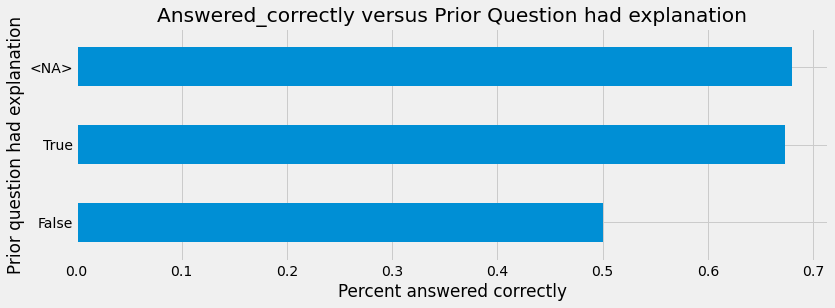

In [16]:
#'prior_question_had_explanation'과 정답률의 관계
# 이전 문제에서 설명을 본 것이, 문제를 맞추는데 도움이 되나?

pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], dropna=False).agg({'answered_correctly': ['mean', 'count']})
#pq.index = pq.index.astype(str)
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh()
# for i, v in zip(pq.index, pq.values):
#     plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Answered_correctly versus Prior Question had explanation")
plt.xlabel("Percent answered correctly")
plt.ylabel("Prior question had explanation")
plt.xticks(rotation=0)
plt.show()


설명을 보는 것이, 다음 문제를 맞히는데 확실히 도움이 되는 것을 확인 할 수 있다.

In [17]:
# 1개의 bundle을 푸는데 걸리는 평균 시간

pq = train[train.answered_correctly != -1]
pq = pq[['prior_question_elapsed_time', 'answered_correctly']]
pq = pq.groupby(['answered_correctly']).agg({'answered_correctly': ['count'], 'prior_question_elapsed_time': ['mean']})

pq

,answered_correctly,prior_question_elapsed_time
,count,mean
answered_correctly,,
0,34026673,25641.992188
1,65244627,25309.976562


오답이든 정답이든, 문제 풀이에 걸리는 시간은 큰 차이가 없는 것을 볼 수 있다.

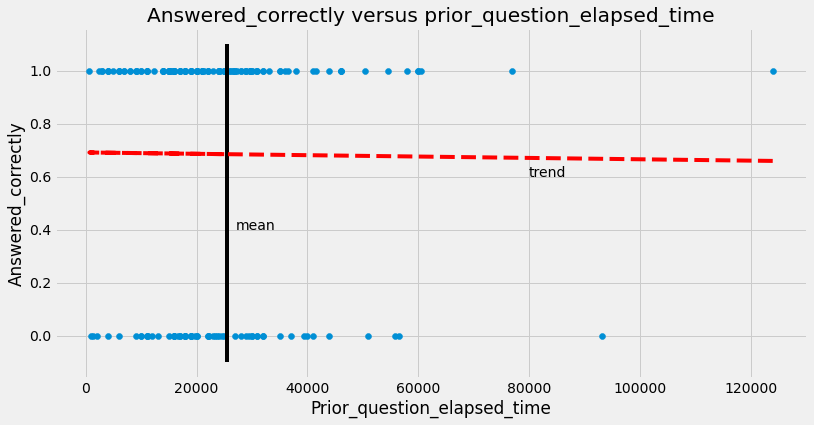

In [19]:
mean_pq = train.prior_question_elapsed_time.astype("float64").mean()

condition = ((train.answered_correctly != -1) & (train.prior_question_elapsed_time.notna()))
pq = train[condition][['prior_question_elapsed_time', 'answered_correctly']].sample(n=200, random_state=1)
pq = pq.set_index('prior_question_elapsed_time').iloc[:,0]

fig = plt.figure(figsize=(12,6))
x = pq.index
y = pq.values
plt.scatter(x, y, marker='o')
plt.title("Answered_correctly versus prior_question_elapsed_time")
plt.xticks(rotation=0)
plt.xlabel("Prior_question_elapsed_time")
plt.ylabel("Answered_correctly")
plt.vlines(mean_pq, ymin=-0.1, ymax=1.1)
plt.text(x= 27000, y=0.4, s='mean')
plt.text(x=80000, y=0.6, s='trend')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

하지만 약간의 downward trend가 있는 것을 확인 할 수 있다.
즉 문제 풀이 시간이 늘어날수록 정답률도 약소하게 떨어진다.
(아마 자신있는 문제라면 떠 빨리 풀고 넘어가지 않을까?)